In [ ]:


av_sig_ver = pd.concat([
    df['AvSigVersion_encoded'].value_counts(),
    round(df['AvSigVersion_encoded'].value_counts()/df.shape[0], 4)*100], 
    axis=1)
av_sig_ver.columns=['Count', '% of total']
HasDetections_AvSigVer = df.groupby('AvSigVersion_encoded')['HasDetections'].mean()
av_sig_ver.merge(HasDetections_AvSigVer, 
                 how='inner', 
                 left_index=True,
                 right_index=True).head(15)

av_sig_ver_idx = av_sig_ver.index.tolist()[:10]
df.loc[~df['AvSigVersion_encoded'].isin(av_sig_ver_idx),
       'AvSigVersion_encoded'] = 'other'

df['AvSigVersion_encoded'].value_counts()/df.shape[0]

df['AvSigVersion_encoded'].dtype

df['AvSigVersion'].dtype

df['AvSigVersion_encoded'] = df['AvSigVersion_encoded'].astype('category')

In [1]:
import pandas as pd
pd.options.display.max_rows = 999
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import pickle
%matplotlib inline

In [2]:
df = pd.read_pickle('../data/interim/train_clean.pickle')
df.head()

,ProductName,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,...,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,AvSigVersion_extracted,AppVersion_extracted,EngineVersion_extracted,OsVer_encoded,Census_OSBranch_release_extracted,IsProtected_encoded,RAM_bins
0,win8defender,7.0,0,53447.0,1.0,1.0,1,29,128035.0,18.0,...,0,10.0,0,273,18,15100,10.0,rs4_release,2,4-8 GB
1,win8defender,7.0,0,53447.0,1.0,1.0,1,93,1482.0,18.0,...,0,8.0,0,263,13,14600,10.0,rs4_release,2,4-8 GB
2,win8defender,7.0,0,53447.0,1.0,1.0,1,86,153579.0,18.0,...,0,3.0,0,273,18,15100,10.0,rs4_release,2,4-8 GB
3,win8defender,7.0,0,53447.0,1.0,1.0,1,88,20710.0,NaN,...,0,3.0,1,273,18,15100,10.0,rs4_release,2,4-8 GB
4,win8defender,7.0,0,53447.0,1.0,1.0,1,18,37376.0,NaN,...,0,1.0,1,273,18,15100,10.0,rs4_release,2,4-8 GB


In [3]:
df.shape

(8921483, 72)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 72 columns):
 #   Column                                             Dtype   
---  ------                                             -----   
 0   ProductName                                        category
 1   RtpStateBitfield                                   category
 2   IsSxsPassiveMode                                   Int64   
 3   AVProductStatesIdentifier                          category
 4   AVProductsInstalled                                category
 5   AVProductsEnabled                                  category
 6   HasTpm                                             Int64   
 7   CountryIdentifier                                  category
 8   CityIdentifier                                     category
 9   OrganizationIdentifier                             category
 10  GeoNameIdentifier                                  category
 11  LocaleEnglishNameIdentifier          

In [5]:
cat_col = df.select_dtypes('category').columns.tolist()
binary_col = df.select_dtypes('Int64').columns.tolist()
num_col = [col for col in df.columns 
           if col not in cat_col
           if col not in binary_col]

## Numerical data

**Univariate Analysis**

In [6]:
df[num_col].head(10)

,Census_ProcessorCoreCount,Census_PrimaryDiskTotalCapacity,Census_SystemVolumeTotalCapacity,Census_TotalPhysicalRAM,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_InternalBatteryNumberOfCharges
0,4.0,476940.0,299451.0,4096.0,18.900000,1440.0,900.0,4.294967e+09
1,4.0,476940.0,102385.0,4096.0,13.900000,1366.0,768.0,1.000000e+00
2,4.0,114473.0,113907.0,4096.0,21.500000,1920.0,1080.0,4.294967e+09
3,4.0,238475.0,227116.0,4096.0,18.500000,1366.0,768.0,4.294967e+09
4,4.0,476940.0,101900.0,6144.0,14.000000,1366.0,768.0,0.000000e+00
5,2.0,114473.0,113671.0,8192.0,21.500000,1920.0,1080.0,4.294967e+09
6,2.0,476940.0,458702.0,4096.0,17.200001,1600.0,900.0,0.000000e+00
7,2.0,305245.0,290807.0,4096.0,15.500000,1366.0,768.0,0.000000e+00
8,4.0,305245.0,303892.0,4096.0,15.600000,1920.0,1080.0,0.000000e+00
9,4.0,953869.0,203252.0,8192.0,15.500000,1366.0,768.0,0.000000e+00


In [7]:
df[num_col].describe().T

,count,mean,std,min,25%,50%,75%,max
Census_ProcessorCoreCount,8880177.0,3.989696e+00,2.082553e+00,1.0,2.0,4.0,4.000000e+00,1.920000e+02
Census_PrimaryDiskTotalCapacity,8868431.0,5.129776e+05,3.564779e+05,0.0,239372.0,476940.0,9.538690e+05,1.526074e+07
Census_SystemVolumeTotalCapacity,8864221.0,3.761297e+05,3.187795e+05,0.0,120775.0,249497.0,4.759700e+05,2.000000e+06
Census_TotalPhysicalRAM,8840950.0,6.115257e+03,5.115821e+03,255.0,4096.0,4096.0,8.192000e+03,1.572864e+06
Census_InternalPrimaryDiagonalDisplaySizeInInches,8874349.0,1.667620e+01,5.892932e+00,0.7,13.9,15.5,1.720000e+01,1.823000e+02
Census_InternalPrimaryDisplayResolutionHorizontal,8874341.0,1.547743e+03,3.683176e+02,144.0,1366.0,1366.0,1.920000e+03,1.228800e+04
Census_InternalPrimaryDisplayResolutionVertical,8874341.0,8.975861e+02,2.145927e+02,171.0,768.0,768.0,1.080000e+03,8.640000e+03
Census_InternalBatteryNumberOfCharges,8652728.0,1.123782e+09,1.887782e+09,0.0,0.0,0.0,4.294967e+09,4.294967e+09


**Census_InternalPrimaryDiagonalDisplaySizeInInches** is continuous, the other variables are discrete.

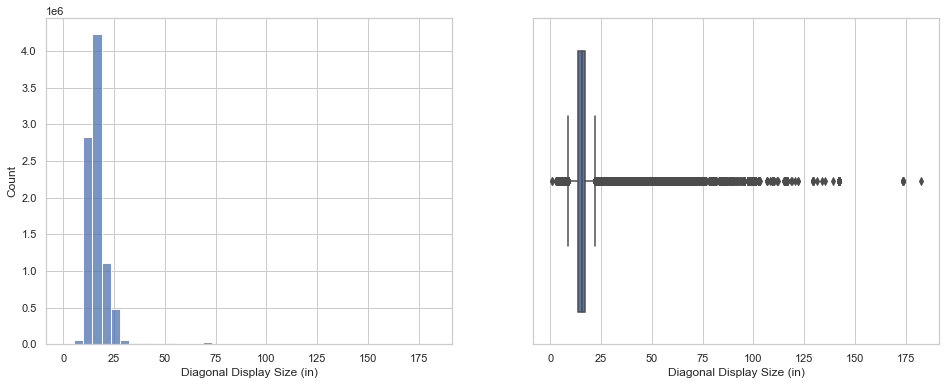

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(ax=axes[0],
             x='Census_InternalPrimaryDiagonalDisplaySizeInInches', 
             data=df,
             bins=40)
axes[0].set_xlabel('Diagonal Display Size (in)');
sns.boxplot(ax=axes[1],
             x='Census_InternalPrimaryDiagonalDisplaySizeInInches', 
             data=df)
axes[1].set_xlabel('Diagonal Display Size (in)');

In [55]:
z = stats.zscore(df['Census_InternalPrimaryDiagonalDisplaySizeInInches'], nan_policy='omit')
z = abs(z)
df['Census_InternalPrimaryDiagonalDisplaySizeInInches_outlier_removed_zscore'] = \
df['Census_InternalPrimaryDiagonalDisplaySizeInInches'][z < 3]

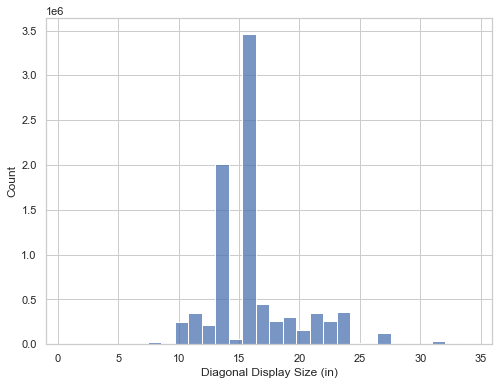

In [57]:
plt.figure(figsize=(8, 6))
sns.histplot(x='Census_InternalPrimaryDiagonalDisplaySizeInInches_outlier_removed_zscore',
             data=df,
             bins=30,)
plt.xlabel('Diagonal Display Size (in)');

Remove outliers based on z scores and then keep both df with outliers and without to test.

In [36]:
df[binary_col] = df[binary_col].astype('float32')

In [37]:
x = df['Census_InternalPrimaryDiagonalDisplaySizeInInches']
y = df['HasDetections']
x.corr(y, method='pearson'), x.corr(y, method='spearman')

(0.034242721461268034, 0.05170876980019068)

In [38]:
x = df['Census_InternalPrimaryDiagonalDisplaySizeInInches_outlier_removed_IQR']
y = df['HasDetections']
x.corr(y, method='pearson'), x.corr(y, method='spearman')

(0.0546142241584952, 0.048895843496819434)

In [39]:
x = df['Census_InternalPrimaryDiagonalDisplaySizeInInches_outlier_removed_zscore']
y = df['HasDetections']
x.corr(y, method='pearson'), x.corr(y, method='spearman')

(0.05608033510182139, 0.05317370722687113)

<AxesSubplot:xlabel='Census_InternalPrimaryDiagonalDisplaySizeInInches', ylabel='HasDetections'>

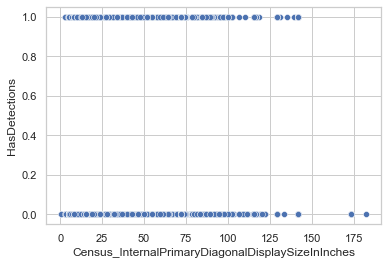

In [172]:
sns.scatterplot(
             x=x,
             y=y)

In [148]:
for col in num_col:
    plt.figure(figsize=(8,6))
    sns.barplot(x=col, data=df)
    plt.xlabel(col);

KeyboardInterrupt: 

<Figure size 576x432 with 0 Axes>

The boxplots show many outliers and extreme values. Let's look at scatterplots in the multivariate analysis. 

**MultivariateAnalysis**

In [92]:
continuos_name_dict = {'Census_InternalPrimaryDiagonalDisplaySizeInInches':'Display Size',
                       'Census_InternalPrimaryDisplayResolutionHorizontal':'Horizontal Resolution',
                       'Census_InternalPrimaryDisplayResolutionVertical':'Vertical Resolution'}

<Figure size 432x288 with 0 Axes>

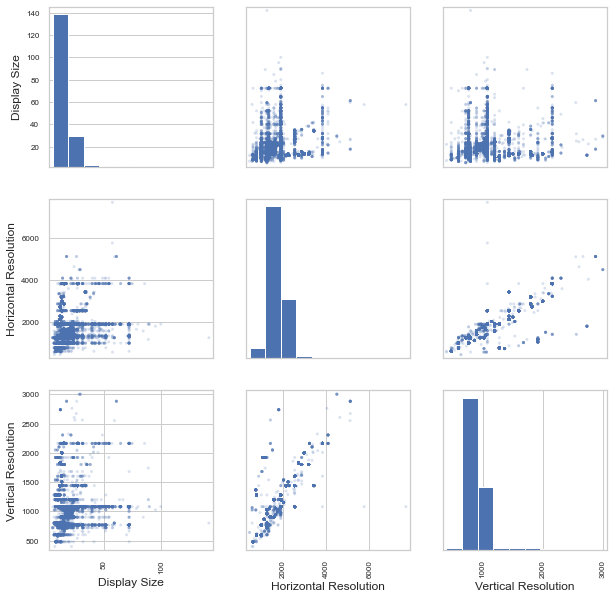

In [93]:
df_sample = df[continuous_num_col].rename(columns=continuos_name_dict).sample(frac=.01)
plt.figure()
pd.plotting.scatter_matrix(df_sample, alpha=0.2, figsize=(10,10))
plt.subplots_adjust(hspace=.2, wspace=.2)

<AxesSubplot:>

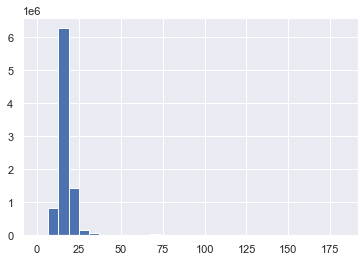

In [41]:


df.Census_InternalPrimaryDiagonalDisplaySizeInInches.hist(bins = 30)

<AxesSubplot:>

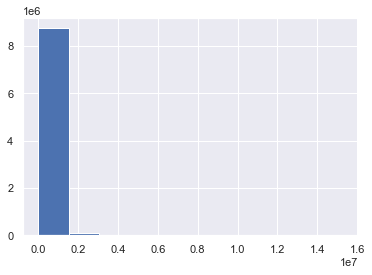

In [44]:
df.Census_PrimaryDiskTotalCapacity.hist()

In [ ]:
plt.subplots(figsize=(16,12))
sns.heatmap(df[numerical_columns + binary_columns].corr());

In [ ]:
# check for categorical encoded nominal

In [ ]:
# define function to create cdf dist plot
def cdf_dist_plots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    #fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    #fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        #ax = axes.flatten()[i]
        ax = sns.displot(data=df, x=col, hue='HasDetections', kind='ecdf')
        ax.set(xlabel=col)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [ ]:
# define function to create kde dist plot
def kde_dist_plots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    #fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    #fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        #ax = axes.flatten()[i]
        ax = sns.displot(data=df, x=col, hue='HasDetections', kind='kde')
        ax.set(xlabel=col)
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [ ]:
cdf_dist_plots(numerical_columns, figsize=(15, 15))

In [ ]:
kde_dist_plots(rank_columns, figsize=(15, 15))

AvSigVersion, AVProductStateIdentifier, Census_ProcessorModelldentifier, Census_OEMNameIdentifier, Census_OSVersion, CountryIdentifier, Census_OSBuildRevision,Census_FirmwareManufacturerIdentifier

In [ ]:
df[['Census_OEMModelIdentifier_encoded',
    'Census_FirmwareVersionIdentifier_encoded',
    'AvSigVersion_encoded', 
    'AVProductStatesIdentifier_encoded',
    'Census_ProcessorModelIdentifier_encoded', 
    'Census_OEMNameIdentifier_encoded', 
    'Census_OSVersion_encoded', 
    'CountryIdentifier_encoded', 
    'Census_OSBuildRevision_encoded', 
    'Census_FirmwareManufacturerIdentifier_encoded',
    'HasDetections']].corr()['HasDetections']

In [ ]:
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, hue='HasDetections', data=df, alpha=.7)
    plt.xticks(rotation=45); 

SmartScreen seems most predictive feature

In [ ]:
for col in binary_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, hue='HasDetections', data=df, alpha=.7)

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='IsProtected', hue='HasDetections', data=df, alpha=.7)
